In [1]:
import numpy as np
import sys
import torch
import torch.nn as nn
sys.path.append('..')
import MLMD

读取XDATCAR文件，步长为2fs

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
LiF = MLMD.atom_io.loadfile(1,"data/XDATCAR")

Reading XDATCAR...
F      : 32
Li     : 30
Loading XDATCAR...
done


制作测试集

In [3]:
train_data = np.array([np.array(np.append(LiF["F"].position[i],LiF["Li"].position[i])) for i in range(len(LiF["F"].position))])

In [4]:
def diff(data):
    #输入train data并差分
    v = []
    for i in range(1,len(data)):
        v.append(data[i]-data[i-1])
    return v
v = diff(train_data)
v[0].reshape(-1,3)[0]

array([ 0.00261522,  0.00183308, -0.01107296])

In [5]:
#print(train_data[1])

以第一帧制作临近表,并将后50帧的路径导入

In [6]:
neighborlist = MLMD.neighbor_list.get_neighbor_atoms(train_data[0].reshape(-1,3),cutoff = 10,lattice = LiF["Li"].lattice)
neighbor_coord = []
for i in range(1000):
    neighboratom = MLMD.neighbor_list.get_coordinates_from_indices(train_data[i].reshape(-1,3),neighborlist)
    for j ,k in enumerate(neighboratom):
        #平移到中心           
        vector_3d = np.tile(train_data[i].reshape(-1,3)[j],(k.shape[0],1))
        if i == 0:
            
            neighbor_coord.append([k-vector_3d])
        else:
            neighbor_coord[j].append(k-vector_3d)

In [7]:
v[299][:3]

array([-0.00654374,  0.00431697, -0.00705332])

In [8]:
neighbor_atom_kind = []
for i in neighborlist:
    atom_kind_list = [1 if x <= 31 else 2 for x in i]
    neighbor_atom_kind.append(atom_kind_list)
print(neighbor_atom_kind[0])#1是F 2是Li

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


至此我们获得了一个名叫neighbor_coord的list，每一项为对应原子序数的临近原子50帧内的运动轨迹，如第0个原子:

In [9]:
#neighbor_coord[0][0]

DNN_sym(
  (activation): ReLU()
  (embed1): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
  )
  (embed2): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
  )
  (embed12): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=8, out_features=3, bias=True)
  (output_acti): Sigmoid()
)
Epoch [50/300], Loss: 0.973889530
Epoch [100/300], Loss: 1.206537008
Epoch [150/300], Loss: 0.568844318
Epoch [200/300], Loss: 2.706071854
Epoch [250/300], Loss: 2.187553883
Epoch [300/300], Loss: 1.989359617


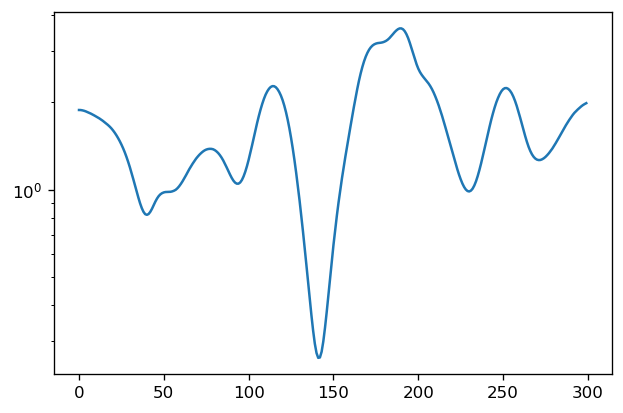

In [10]:
#模型的构建
embed_layers = [6]
linear_layers = [64,32,8]
atom = 1
atom_list = neighbor_atom_kind[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLMD.model2.DNN_sym(atom, atom_list, embed_layers, linear_layers).to(device)
print(model)


num_epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_array = []   #draw picture

# 训练第一个原子的临近行为
for epoch in range(num_epochs):
    # Get the input and target arrays
    
    input_array = torch.from_numpy(neighbor_coord[0][epoch]*100).float().to(device)
    #print(input_array)
    target_array = torch.from_numpy(v[epoch].reshape(-1,3)[0]*100).float().to(device)   #train_data+1 v不加
    #print(epoch,input_array,target_array)
    # Forward pass
    output_array = model(input_array)

    # Compute the loss
    loss = criterion(output_array, target_array)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 50 == 0:
        print('Epoch [{}/{}], Loss: {:.9f}'.format(epoch+1, num_epochs, loss.item()))
    loss_array.append(loss.item())

import matplotlib.pyplot as plt
plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")

In [11]:
print(target_array,output_array,loss)#老是0或1 怎么会是呢

tensor([-0.6544,  0.4317, -0.7053], device='cuda:0') tensor([1., 1., 1.], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor(1.9894, device='cuda:0', grad_fn=<MseLossBackward0>)


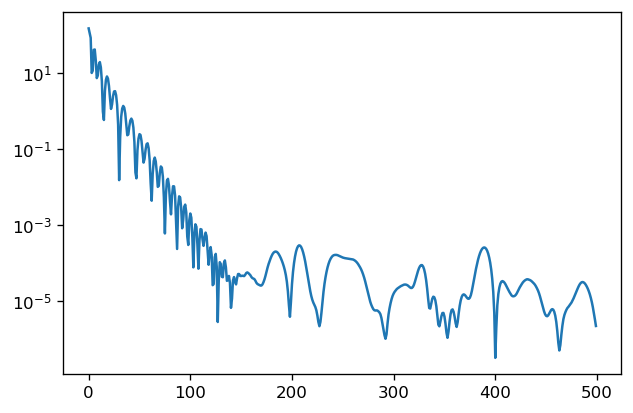

In [237]:
import matplotlib.pyplot as plt
plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")

tensor([ 0.0034,  0.0043, -0.0069], device='cuda:0') tensor([7.7868e-07, 1.4028e-07, 6.0318e-07], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


用前一帧的路径去预测下一帧速度

In [7]:
fwd = 1

In [60]:
# Create a MyDNN instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLMD.model.MyDNN(1).to(device)

num_epochs = 1000

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_array = []   #draw picture

# Train the model
for epoch in range(num_epochs):
    # Get the input and target arrays
    
    input_array = torch.from_numpy(train_data[epoch:epoch+fwd].reshape(-1)).float().to(device)
    target_array = torch.from_numpy(v[epoch+fwd-1].reshape(-1)).float().to(device)   #train_data+1 v不加
    #print(epoch,input_array,target_array)
    # Forward pass
    output_array = model(input_array)

    # Compute the loss
    loss = criterion(output_array, target_array)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 50 == 0:
        print('Epoch [{}/{}], Loss: {:.9f}'.format(epoch+1, num_epochs, loss.item()))
    loss_array.append(loss.item())



NameError: name 'fwd' is not defined

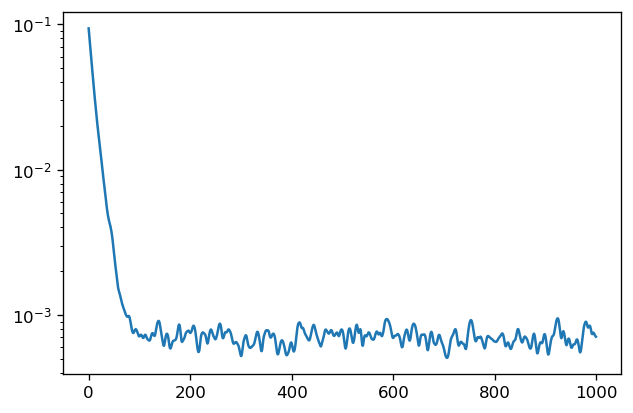

In [10]:
import matplotlib.pyplot as plt
import os


plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")

# 把最后一帧的速度作为输出和目标进行一个对比

In [9]:
#
#print(output_array)
#print(target_array)
#print(criterion(output_array, target_array))

用frame的前五帧预测下一帧

In [9]:
# Get the input array for prediction
frame = 200
input_array = torch.from_numpy(train_data[frame-1:frame].reshape(-1)).float().to(device)

# Predict the output array
with torch.no_grad():
    output_array = model(input_array)

# Convert the output tensor to a numpy array
output_array = output_array.cpu().numpy() + train_data[frame-1:frame].reshape(-1)

In [144]:
#print(output_array.reshape(-1,3))

In [145]:
import ase
from ase.io import read ,write
from ase.build import sort
from ase.visualize import view

# 将某一帧写出

In [12]:
"""with open('LiF.vasp', 'w') as f:
    f.write("vasp\n")
    f.write("1.0\n")
    for i in (LiF["F"].lattice):
        f.write(str(i)[1:-1]+"\n")
    for (i,j) in LiF.items():
        f.write(j.name + " ")
    f.write("\n")
    for (i,j) in LiF.items():
        f.write(str(j.number) + " ")
    f.write("\n")
    f.write("Direct\n")
    for i in output_array.reshape(-1,3):
        f.write(str(i)[1:-1]+"\n")
bulk = read("LiF.vasp")
view(bulk)"""

'with open(\'LiF.vasp\', \'w\') as f:\n    f.write("vasp\n")\n    f.write("1.0\n")\n    for i in (LiF["F"].lattice):\n        f.write(str(i)[1:-1]+"\n")\n    for (i,j) in LiF.items():\n        f.write(j.name + " ")\n    f.write("\n")\n    for (i,j) in LiF.items():\n        f.write(str(j.number) + " ")\n    f.write("\n")\n    f.write("Direct\n")\n    for i in output_array.reshape(-1,3):\n        f.write(str(i)[1:-1]+"\n")\nbulk = read("LiF.vasp")\nview(bulk)'

# 跑100步写成xdatcar00

In [13]:
running_test = []
running_test.append(train_data[1000].tolist())

In [16]:
#def pbc_res(frame):
#    #在更新位置时考虑周期性边界条件
#    frame[frame < 0] += 1
#    frame[frame > 1] -= 1
#    return np.array(frame)

for i in range(100):
    input_array = torch.from_numpy(np.array(running_test[-1]).reshape(-1)).float().to(device)
    with torch.no_grad():
        output_array = model(input_array)
    running_test.append(output_array.cpu().numpy() + np.array(running_test[-1]).reshape(-1))
with open('XDATCAR00', 'w') as f:
    f.write("vasp\n")
    f.write("1.0\n")
    for i in (LiF["F"].lattice):
        f.write(str(i)[1:-1]+"\n")
    for (i,j) in LiF.items():
        f.write(j.name + " ")
    f.write("\n")
    for (i,j) in LiF.items():
        f.write(str(j.number) + " ")
    f.write("\n")
    for i in range(len(running_test)):
        f.write("Direct configuration=       "+str(i+1)+"\n")
        for j in np.array(running_test[i]).reshape(-1,3):
            f.write(str(j)[1:-1]+"\n")    